In today's post I want to examine whether Google Trend data has predictive power for cryptocurrencies. That, by carry out some VARs. This includes the use of pytrends to import google trend data into python. The Prices of the cryptocurrencies(here Bitcoin/EUR, Ethereum/BTC and Zcash/BTC) are taken from quandl with the use of the quandl API for python. So let's start importing the necessary packages.

In [1]:
from pytrends.request import TrendReq
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import quandl

To make use of the pytrends packages you need a google account, otherwise it won't work, I suppose. Quandl also wants an API token, such that you can fetch an unlimited amount of data. Thus, we define the necessary credentials, start and end date and the quandl codes to fetch the data. Please note here: If we want to analyze the data on a daily basis, it's only possible for the last 90 days. Google only reports daily search volume for the last 90 days, if we define a longer time horizon, google would return weekly data. This is a pity but anyway, let's continue. 

In [2]:
google_username = 'maegi.burri@bluewin.ch'
google_password = "mb12n063"
QuandlToken = "Szd-sakmLdRquUfmekxC"
EndDate = datetime.datetime.now().date()
StartDate = EndDate - datetime.timedelta(days=89)
quandlcodes = ["GDAX/EUR.1","BITFINEX/ETHBTC.4", "BITFINEX/ZECBTC.4"]

I choose the way to import each currency separately, such that every currency reaches somewhere the maximum value of 100 in the google statistics. Otherwise(all imported together) only bitcoin would reach this maximum value and zcash had a 0 most of the time. This would look like the following:

In [3]:
data = quandl.get(quandlcodes,authtoken=QuandlToken, trim_start=StartDate, trim_end=EndDate, paginate=True, 
                  qopts={'columns':['ticker', 'per_end_date']})

# connect to Google
pytrend = TrendReq(google_username, google_password, custom_useragent=None)

trend_payload = {'q': 'Bitcoin','date': 'today 90-d'}
gtrendbtc = pytrend.trend(trend_payload, return_type='dataframe')
trend_payload = {'q': 'Ethereum','date': 'today 90-d'}
gtrendeth = pytrend.trend(trend_payload, return_type='dataframe')
trend_payload = {'q': 'Zcash','date': 'today 90-d'}
gtrendzec = pytrend.trend(trend_payload, return_type='dataframe')
gtrend = pd.concat([gtrendbtc, gtrendeth, gtrendzec], axis = 1) 

trend_payload = {'q': 'Bitcoin, Ethereum, Zcash','date': 'today 90-d'}
gtrendall = pytrend.trend(trend_payload, return_type='dataframe')

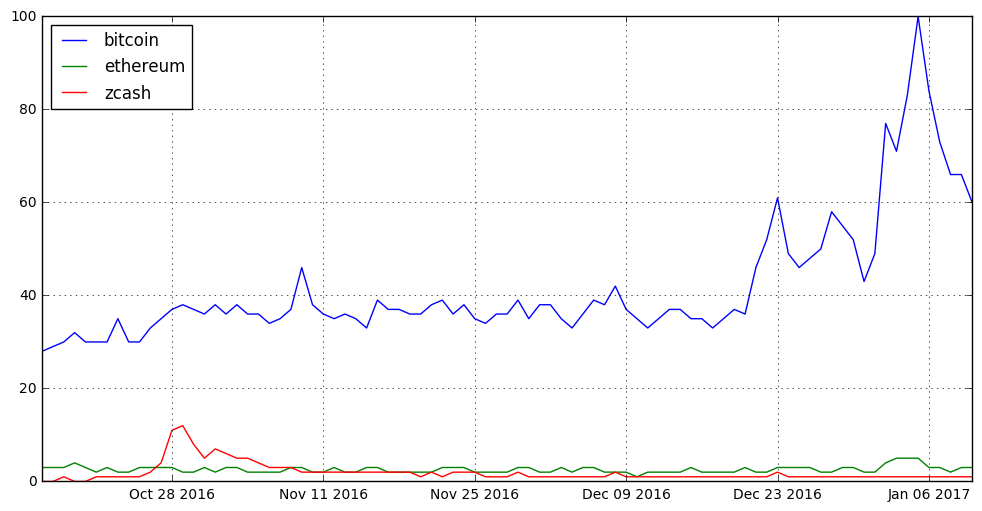

In [4]:
# Graph
fig, ax = plt.subplots(1,figsize=(12,6))
ax.grid()
ax.plot(gtrendall)
ax.legend(list(gtrendall.columns),loc=2)
plt.show(fig)

For the analysis we convert the prices to Euro and calculate growth rates of the google trend statistics:

In [5]:
DF = pd.concat([gtrend, data], axis = 1) 
AllData = DF.dropna()
AllData.iloc[:,4] =  AllData.iloc[:,4]*AllData.iloc[:,3] 
AllData.iloc[:,5] =  AllData.iloc[:,5]*AllData.iloc[:,3] 
AllData.columns = ['bitcoin', 'ethereum', 'zcash','BTC/EUR', 'ETH/EUR','ZEC/EUR']
prcntdta = AllData.pct_change()*100
AllData.corr()

/Users/marcburri/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,bitcoin,ethereum,zcash,BTC/EUR,ETH/EUR,ZEC/EUR
bitcoin,1.000000,0.703493,-0.220455,0.834460,0.084882,-0.179142
ethereum,0.703493,1.000000,-0.054122,0.514216,0.073768,-0.097767
zcash,-0.220455,-0.054122,1.000000,-0.453619,0.461441,0.767814
BTC/EUR,0.834460,0.514216,-0.453619,1.000000,-0.233093,-0.382175
ETH/EUR,0.084882,0.073768,0.461441,-0.233093,1.000000,0.397930
ZEC/EUR,-0.179142,-0.097767,0.767814,-0.382175,0.397930,1.000000


From the previous table, we see that those time series are highly correlated. Now let's see some graphs 

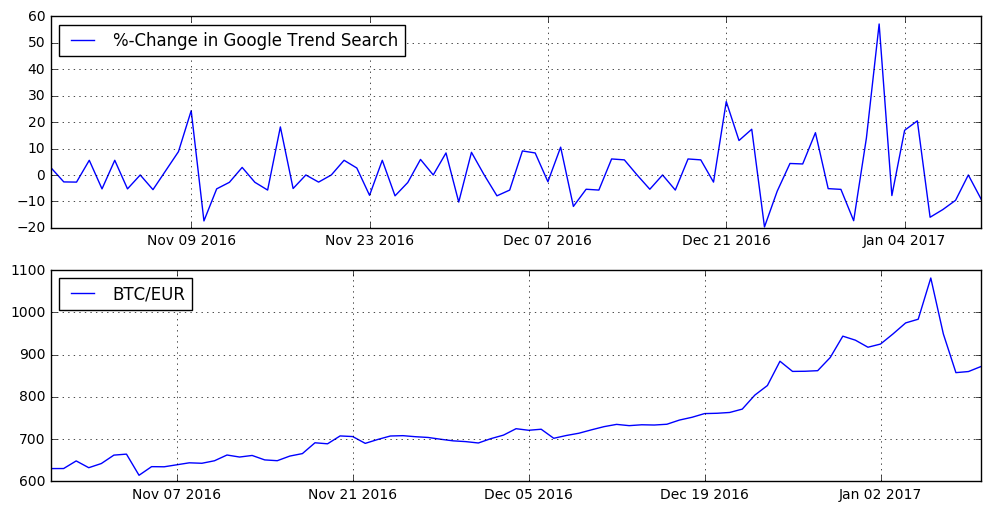

In [6]:
# Graph
fig, ax = plt.subplots(2,figsize=(12,6))
ax[0].grid()
ax[0].plot(prcntdta.iloc[:,0])
ax[0].legend(["%-Change in Google Trend Search"],loc=2)
ax[1].plot(AllData.iloc[:,3])
ax[1].grid()
ax[1].legend(['BTC/EUR'],loc=2)
plt.show(fig)

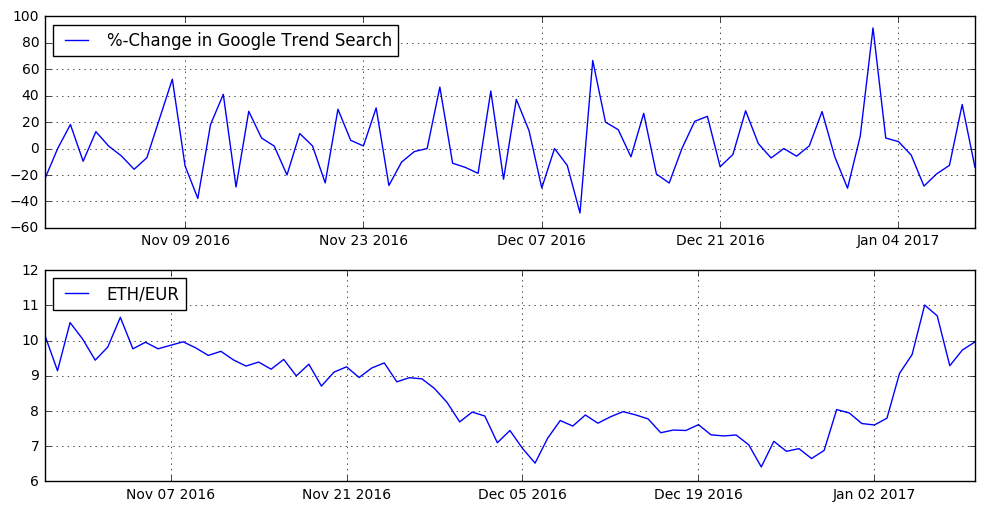

In [7]:
fig, ax = plt.subplots(2,figsize=(12,6))
ax[0].grid()
ax[0].plot(prcntdta.iloc[:,1])
ax[0].legend(["%-Change in Google Trend Search"],loc=2)
ax[1].plot(AllData.iloc[:,4])
ax[1].grid()
ax[1].legend(['ETH/EUR'],loc=2)
plt.show(fig)

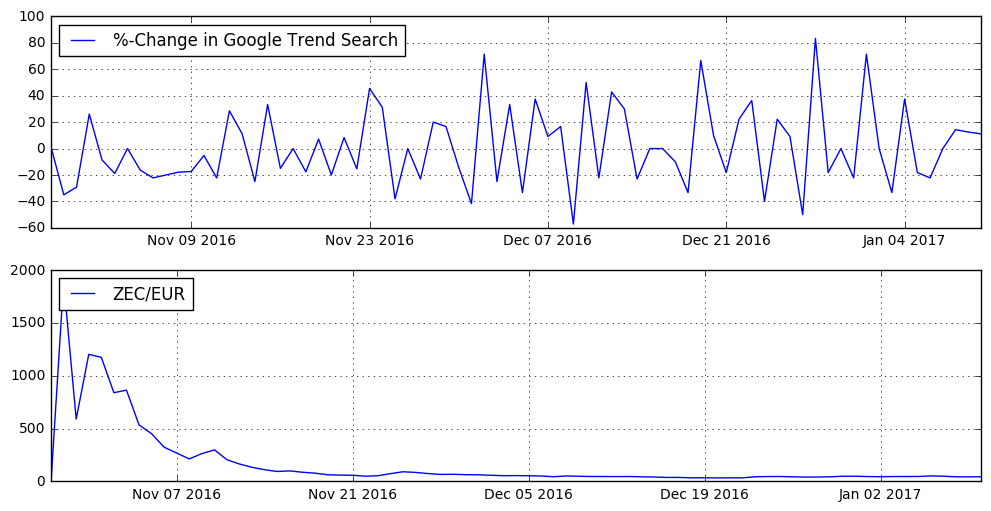

In [8]:
fig, ax = plt.subplots(2,figsize=(12,6))
ax[0].grid()
ax[0].plot(prcntdta.iloc[:,2])
ax[0].legend(["%-Change in Google Trend Search"],loc=2)
ax[1].plot(AllData.iloc[:,5])
ax[1].grid()
ax[1].legend(['ZEC/EUR'],loc=2)
plt.show(fig)

Now let's try to quantify the connection between the google trends statistics growth rate and price of the currency. That is we estimate bivariate VARs of order 1. The following are the results of these VARs:

In [9]:
# Statespace
dta = pd.concat([AllData['BTC/EUR'].iloc[2:74],prcntdta['bitcoin'].iloc[2:74]], axis=1)
mod = sm.tsa.VARMAX(dta,  order=(1,0), enforce_invertibility=True)
res = mod.fit(maxiter=5000, disp = False)
print(res.summary())

/Users/marcburri/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:229: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             Statespace Model Results                             
Dep. Variable:     ['BTC/EUR', 'bitcoin']   No. Observations:                   72
Model:                             VAR(1)   Log Likelihood                -619.689
                              + intercept   AIC                           1257.377
Date:                    Fri, 13 Jan 2017   BIC                           1277.867
Time:                            20:11:55   HQIC                          1265.535
Sample:                                 0                                         
                                     - 72                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                20.29, 32.78   Jarque-Bera (JB):       207.19, 118.43
Prob(Q):                        1.00, 0.78   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         5.09, 4.18   Skew:                      -1.23, 1.58
P

In [10]:
# Statespace
dta = pd.concat([AllData['ETH/EUR'].iloc[2:74],prcntdta['ethereum'].iloc[2:74]], axis=1)
mod = sm.tsa.VARMAX(dta,  order=(1,0), enforce_invertibility=True)
res = mod.fit(maxiter=5000, disp = False)
print(res.summary())

/Users/marcburri/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:229: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              Statespace Model Results                             
Dep. Variable:     ['ETH/EUR', 'ethereum']   No. Observations:                   72
Model:                              VAR(1)   Log Likelihood                -383.468
                               + intercept   AIC                            784.936
Date:                     Fri, 13 Jan 2017   BIC                            805.426
Time:                             20:11:56   HQIC                           793.093
Sample:                                  0                                         
                                      - 72                                         
Covariance Type:                       opg                                         
Ljung-Box (Q):                34.06, 55.39   Jarque-Bera (JB):           6.45, 9.95
Prob(Q):                        0.73, 0.05   Prob(JB):                   0.04, 0.01
Heteroskedasticity (H):         2.31, 1.39   Skew:                       0.3

In [11]:
# Statespace
dta = pd.concat([AllData['ZEC/EUR'].iloc[2:74],prcntdta['zcash'].iloc[2:74]], axis=1)
mod = sm.tsa.VARMAX(dta,  order=(1,0), enforce_invertibility=True)
res = mod.fit(maxiter=5000, disp = False)
print(res.summary())

/Users/marcburri/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:229: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                            Statespace Model Results                            
Dep. Variable:     ['ZEC/EUR', 'zcash']   No. Observations:                   72
Model:                           VAR(1)   Log Likelihood                -769.140
                            + intercept   AIC                           1556.281
Date:                  Fri, 13 Jan 2017   BIC                           1576.771
Time:                          20:11:57   HQIC                          1564.438
Sample:                               0                                         
                                   - 72                                         
Covariance Type:                    opg                                         
Ljung-Box (Q):                13.41, 47.17   Jarque-Bera (JB):        2299.67, 1.63
Prob(Q):                        1.00, 0.20   Prob(JB):                   0.00, 0.44
Heteroskedasticity (H):         0.01, 2.39   Skew:                       3.40, 0.23
Prob(H) (two-sided)

We see that the only significant google trends statistics growth rate is the one of bitcoin. This means we cannot conclude that google has predictive power in this case. But we have to state here that this is a very very simple application and we only observe data for the last 90 days, therefore this analysis is not really meangingful. Even if we have no meaningful results, this post shows how to use pytrends. Maybe it is the wrong branch to use google trend data and it would be more fruitful if we apply this procedure to a branch like tourism (because many people google where they want tp spend their holidays).